# 행동 스티커 만들기

목차

- 라이브러리 임포트

- 데이터 셋 로드

- 파싱 함수 구현

- TFRecord 파일 생성

- ray 패키지로 병렬 처리

- TFRecord 생성

- 모델에 필요한 데이터로 변환

- keypoint 를 heatmap 으로 변경

- 데이터 전처리

- 모델 - Hourglass

- intermediate output을 위한 linear layer

- stacked hourglass

- 모델 - Simplebaseline

- 학습 엔진

- 데이터 셋 제작

- StackedHourglassNetwork 학습

- 예측 엔진

- StackedHourglass 모델 결과

## 라이브러리 임포트

In [1]:
#ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있음
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

---

## 데이터 셋 로드

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


---

## 파싱 함수 구현

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


---

## TFRecord 파일 생성

In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

---

## ray 패키지로 병렬 처리

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

---

## TFRecord 생성

In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2022-08-15 14:16:59,487	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.96gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=139) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=139) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=141) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=141) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=140) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=140) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=139) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=139) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=139) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=139) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=141) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=141) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=139) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=139) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=140) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=140) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

---

## 모델에 필요한 데이터로 변환

In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

(build_single_tfrecord pid=140) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

---

## keypoint 를 heatmap 으로 변경

In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

---

## 데이터 전처리

In [14]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

---

## 모델 - Hourglass

In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

---

## intermediate output을 위한 linear layer

In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

---

## stacked hourglass

In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

---

## 모델 - Simplebaseline

In [19]:
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [20]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(2,2), strides=2))
        seq_model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [21]:
upconv = _make_deconv_layer(3)

In [22]:
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

In [34]:
def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

---

## 학습 엔진

In [35]:
class Trainer(object):
    def __init__(self,
                model_file_name,
                model,
                epochs,
                global_batch_size,
                strategy,
                initial_learning_rate):

        self.model_file_name = model_file_name
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/{}-epoch-{}-loss-{:.4f}.h5'.format(self.model_file_name, epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

---

## 데이터 셋 제작

In [36]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [37]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, model_file_name='model', is_stackedhourglassnetwork=True):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        
        if is_stackedhourglassnetwork:
            model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        else:
            model = Simplebaseline(IMAGE_SHAPE)

        trainer = Trainer(
            model_file_name,
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

---

## StackedHourglassNetwork 학습

In [38]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [29]:
best_model_SHN_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, 'model_SHN', is_stackedhourglassnetwork=True)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.26788616 epoch total loss 2.26788616
Trained batch 2 batch loss 2.16127491 epoch total loss 2.21458054
Trained batch 3 batch loss 2.31869864 epoch total loss 2.24928665
Trained batch 4 batch loss 2.08849907 epoch total loss 2.20908976
Trained batch 5 batch loss 2.04567075 epoch total loss 2.17640591
Trained batch 6 batch loss 2.02959561 epoch total loss 2.15193748
Trained batch 7 batch loss 2.0114181 epoch total loss 2.13186336
Trained batch 8 batch loss 2.07697 epoch total loss 2.12500167
Trained batch 9 batch loss 2.22638083 epoch total loss 2.13626599
Trained batch 10 batch loss 2.20918655 epoch total loss 2.14355803
Trained batch 11 batch loss 2.20327187 epoch total loss 2.14898658
Trained batch 12 batch loss 2.16363192 epoch total loss 2.15020704
Trained batch 13 batch loss 2.17391062 epoch total loss 2.15203047
Trained batch 14 batch loss 2.0163908 epoch total loss 2.14234185
Trained batch 15 batch loss 1.77077973 epoch 

Trained batch 124 batch loss 1.73343384 epoch total loss 1.78104603
Trained batch 125 batch loss 1.65691233 epoch total loss 1.7800529
Trained batch 126 batch loss 1.64016747 epoch total loss 1.7789427
Trained batch 127 batch loss 1.67110658 epoch total loss 1.77809358
Trained batch 128 batch loss 1.66235161 epoch total loss 1.77718937
Trained batch 129 batch loss 1.55202 epoch total loss 1.77544391
Trained batch 130 batch loss 1.5783993 epoch total loss 1.77392817
Trained batch 131 batch loss 1.66414857 epoch total loss 1.77309012
Trained batch 132 batch loss 1.70923734 epoch total loss 1.77260649
Trained batch 133 batch loss 1.68635654 epoch total loss 1.77195799
Trained batch 134 batch loss 1.68762898 epoch total loss 1.77132857
Trained batch 135 batch loss 1.46417665 epoch total loss 1.76905334
Trained batch 136 batch loss 1.42035151 epoch total loss 1.76648939
Trained batch 137 batch loss 1.61675072 epoch total loss 1.76539636
Trained batch 138 batch loss 1.70360076 epoch total lo

Trained batch 245 batch loss 1.53616035 epoch total loss 1.70244861
Trained batch 246 batch loss 1.58769214 epoch total loss 1.70198202
Trained batch 247 batch loss 1.63808835 epoch total loss 1.70172346
Trained batch 248 batch loss 1.68336272 epoch total loss 1.70164931
Trained batch 249 batch loss 1.75065064 epoch total loss 1.70184612
Trained batch 250 batch loss 1.63657641 epoch total loss 1.70158494
Trained batch 251 batch loss 1.61913705 epoch total loss 1.70125651
Trained batch 252 batch loss 1.60006356 epoch total loss 1.7008549
Trained batch 253 batch loss 1.51494312 epoch total loss 1.70012021
Trained batch 254 batch loss 1.60660315 epoch total loss 1.69975197
Trained batch 255 batch loss 1.51927125 epoch total loss 1.69904411
Trained batch 256 batch loss 1.59053433 epoch total loss 1.69862032
Trained batch 257 batch loss 1.59800434 epoch total loss 1.69822872
Trained batch 258 batch loss 1.60598731 epoch total loss 1.69787121
Trained batch 259 batch loss 1.57978868 epoch tot

Trained batch 366 batch loss 1.59428596 epoch total loss 1.67261875
Trained batch 367 batch loss 1.55179965 epoch total loss 1.67228961
Trained batch 368 batch loss 1.66152263 epoch total loss 1.67226028
Trained batch 369 batch loss 1.607458 epoch total loss 1.67208469
Trained batch 370 batch loss 1.62918448 epoch total loss 1.67196882
Trained batch 371 batch loss 1.72104454 epoch total loss 1.67210126
Trained batch 372 batch loss 1.67363489 epoch total loss 1.67210531
Trained batch 373 batch loss 1.76307535 epoch total loss 1.67234921
Trained batch 374 batch loss 1.66797495 epoch total loss 1.67233753
Trained batch 375 batch loss 1.6529187 epoch total loss 1.67228568
Trained batch 376 batch loss 1.57739186 epoch total loss 1.67203331
Trained batch 377 batch loss 1.55051279 epoch total loss 1.67171097
Trained batch 378 batch loss 1.65901351 epoch total loss 1.67167735
Trained batch 379 batch loss 1.61757231 epoch total loss 1.67153454
Trained batch 380 batch loss 1.6543026 epoch total 

Trained batch 488 batch loss 1.50083423 epoch total loss 1.64715123
Trained batch 489 batch loss 1.46401954 epoch total loss 1.64677668
Trained batch 490 batch loss 1.49411774 epoch total loss 1.64646518
Trained batch 491 batch loss 1.55402982 epoch total loss 1.64627695
Trained batch 492 batch loss 1.43274903 epoch total loss 1.64584291
Trained batch 493 batch loss 1.59998035 epoch total loss 1.64574981
Trained batch 494 batch loss 1.7063694 epoch total loss 1.64587259
Trained batch 495 batch loss 1.62057889 epoch total loss 1.64582145
Trained batch 496 batch loss 1.46836674 epoch total loss 1.64546371
Trained batch 497 batch loss 1.45973778 epoch total loss 1.64509
Trained batch 498 batch loss 1.41008306 epoch total loss 1.64461815
Trained batch 499 batch loss 1.45748043 epoch total loss 1.64424312
Trained batch 500 batch loss 1.59814942 epoch total loss 1.64415085
Trained batch 501 batch loss 1.36036015 epoch total loss 1.64358437
Trained batch 502 batch loss 1.38442254 epoch total 

Trained batch 609 batch loss 1.51471221 epoch total loss 1.62261307
Trained batch 610 batch loss 1.58637381 epoch total loss 1.62255359
Trained batch 611 batch loss 1.55592787 epoch total loss 1.62244451
Trained batch 612 batch loss 1.58457327 epoch total loss 1.62238264
Trained batch 613 batch loss 1.63941932 epoch total loss 1.62241042
Trained batch 614 batch loss 1.62287688 epoch total loss 1.62241113
Trained batch 615 batch loss 1.54974508 epoch total loss 1.622293
Trained batch 616 batch loss 1.44672704 epoch total loss 1.62200797
Trained batch 617 batch loss 1.36190021 epoch total loss 1.62158644
Trained batch 618 batch loss 1.41405058 epoch total loss 1.62125063
Trained batch 619 batch loss 1.38984931 epoch total loss 1.62087667
Trained batch 620 batch loss 1.35753584 epoch total loss 1.62045205
Trained batch 621 batch loss 1.30341184 epoch total loss 1.61994147
Trained batch 622 batch loss 1.31689703 epoch total loss 1.61945426
Trained batch 623 batch loss 1.24580026 epoch tota

Trained batch 731 batch loss 1.64263153 epoch total loss 1.60185838
Trained batch 732 batch loss 1.6143223 epoch total loss 1.60187554
Trained batch 733 batch loss 1.56660545 epoch total loss 1.6018275
Trained batch 734 batch loss 1.49365473 epoch total loss 1.60168
Trained batch 735 batch loss 1.5816195 epoch total loss 1.60165286
Trained batch 736 batch loss 1.56888306 epoch total loss 1.60160828
Trained batch 737 batch loss 1.56062734 epoch total loss 1.60155272
Trained batch 738 batch loss 1.52784657 epoch total loss 1.60145283
Trained batch 739 batch loss 1.46849346 epoch total loss 1.60127294
Trained batch 740 batch loss 1.51203108 epoch total loss 1.60115242
Trained batch 741 batch loss 1.51968312 epoch total loss 1.60104239
Trained batch 742 batch loss 1.52590978 epoch total loss 1.60094118
Trained batch 743 batch loss 1.54265642 epoch total loss 1.60086262
Trained batch 744 batch loss 1.71517277 epoch total loss 1.60101628
Trained batch 745 batch loss 1.66082656 epoch total lo

Trained batch 853 batch loss 1.56141019 epoch total loss 1.59055889
Trained batch 854 batch loss 1.52040136 epoch total loss 1.59047663
Trained batch 855 batch loss 1.41629124 epoch total loss 1.5902729
Trained batch 856 batch loss 1.43113899 epoch total loss 1.59008706
Trained batch 857 batch loss 1.4999404 epoch total loss 1.58998191
Trained batch 858 batch loss 1.64308834 epoch total loss 1.59004378
Trained batch 859 batch loss 1.44006383 epoch total loss 1.58986914
Trained batch 860 batch loss 1.42398298 epoch total loss 1.58967626
Trained batch 861 batch loss 1.49019051 epoch total loss 1.58956075
Trained batch 862 batch loss 1.48947859 epoch total loss 1.58944464
Trained batch 863 batch loss 1.43008161 epoch total loss 1.58926
Trained batch 864 batch loss 1.48249984 epoch total loss 1.58913648
Trained batch 865 batch loss 1.5177002 epoch total loss 1.58905387
Trained batch 866 batch loss 1.46577501 epoch total loss 1.58891153
Trained batch 867 batch loss 1.50187826 epoch total lo

Trained batch 974 batch loss 1.44691575 epoch total loss 1.57839394
Trained batch 975 batch loss 1.37109685 epoch total loss 1.57818139
Trained batch 976 batch loss 1.45415962 epoch total loss 1.57805419
Trained batch 977 batch loss 1.34552372 epoch total loss 1.57781625
Trained batch 978 batch loss 1.38234949 epoch total loss 1.57761633
Trained batch 979 batch loss 1.51372159 epoch total loss 1.57755101
Trained batch 980 batch loss 1.52538192 epoch total loss 1.57749784
Trained batch 981 batch loss 1.49763513 epoch total loss 1.57741642
Trained batch 982 batch loss 1.41310871 epoch total loss 1.57724917
Trained batch 983 batch loss 1.39468193 epoch total loss 1.57706332
Trained batch 984 batch loss 1.45947933 epoch total loss 1.57694387
Trained batch 985 batch loss 1.3794477 epoch total loss 1.57674336
Trained batch 986 batch loss 1.43225503 epoch total loss 1.57659674
Trained batch 987 batch loss 1.35580325 epoch total loss 1.5763731
Trained batch 988 batch loss 1.41315877 epoch tota

Trained batch 1094 batch loss 1.4438796 epoch total loss 1.56835938
Trained batch 1095 batch loss 1.51571131 epoch total loss 1.56831133
Trained batch 1096 batch loss 1.46383536 epoch total loss 1.56821609
Trained batch 1097 batch loss 1.58743382 epoch total loss 1.56823349
Trained batch 1098 batch loss 1.50344729 epoch total loss 1.56817448
Trained batch 1099 batch loss 1.549896 epoch total loss 1.56815791
Trained batch 1100 batch loss 1.50816059 epoch total loss 1.56810331
Trained batch 1101 batch loss 1.59148288 epoch total loss 1.56812453
Trained batch 1102 batch loss 1.59325683 epoch total loss 1.5681473
Trained batch 1103 batch loss 1.53757095 epoch total loss 1.56811965
Trained batch 1104 batch loss 1.58921754 epoch total loss 1.56813884
Trained batch 1105 batch loss 1.5822165 epoch total loss 1.56815159
Trained batch 1106 batch loss 1.44427669 epoch total loss 1.56803966
Trained batch 1107 batch loss 1.40976369 epoch total loss 1.56789672
Trained batch 1108 batch loss 1.5955493

Trained batch 1214 batch loss 1.36151373 epoch total loss 1.55830491
Trained batch 1215 batch loss 1.47003031 epoch total loss 1.55823219
Trained batch 1216 batch loss 1.49066937 epoch total loss 1.55817664
Trained batch 1217 batch loss 1.49259794 epoch total loss 1.55812275
Trained batch 1218 batch loss 1.42729402 epoch total loss 1.55801523
Trained batch 1219 batch loss 1.42894948 epoch total loss 1.55790937
Trained batch 1220 batch loss 1.42349219 epoch total loss 1.55779922
Trained batch 1221 batch loss 1.47961617 epoch total loss 1.5577352
Trained batch 1222 batch loss 1.46752369 epoch total loss 1.55766129
Trained batch 1223 batch loss 1.46925199 epoch total loss 1.55758905
Trained batch 1224 batch loss 1.41266382 epoch total loss 1.55747068
Trained batch 1225 batch loss 1.55173767 epoch total loss 1.55746603
Trained batch 1226 batch loss 1.48983335 epoch total loss 1.55741084
Trained batch 1227 batch loss 1.46577203 epoch total loss 1.55733621
Trained batch 1228 batch loss 1.439

Trained batch 1334 batch loss 1.36719942 epoch total loss 1.54800546
Trained batch 1335 batch loss 1.33006597 epoch total loss 1.54784226
Trained batch 1336 batch loss 1.33601117 epoch total loss 1.5476836
Trained batch 1337 batch loss 1.48117864 epoch total loss 1.54763389
Trained batch 1338 batch loss 1.43654585 epoch total loss 1.54755092
Trained batch 1339 batch loss 1.482342 epoch total loss 1.54750216
Trained batch 1340 batch loss 1.41313839 epoch total loss 1.54740191
Trained batch 1341 batch loss 1.37492847 epoch total loss 1.5472734
Trained batch 1342 batch loss 1.35273671 epoch total loss 1.54712844
Trained batch 1343 batch loss 1.329445 epoch total loss 1.54696631
Trained batch 1344 batch loss 1.29972029 epoch total loss 1.54678237
Trained batch 1345 batch loss 1.39445162 epoch total loss 1.54666913
Trained batch 1346 batch loss 1.43676388 epoch total loss 1.54658747
Trained batch 1347 batch loss 1.45772564 epoch total loss 1.54652154
Trained batch 1348 batch loss 1.30164719

Validated batch 109 batch loss 1.36023879
Validated batch 110 batch loss 1.51587844
Validated batch 111 batch loss 1.34535885
Validated batch 112 batch loss 1.36459064
Validated batch 113 batch loss 1.39508748
Validated batch 114 batch loss 1.39475834
Validated batch 115 batch loss 1.52507389
Validated batch 116 batch loss 1.49853396
Validated batch 117 batch loss 1.42243767
Validated batch 118 batch loss 1.38974535
Validated batch 119 batch loss 1.36719191
Validated batch 120 batch loss 1.38490713
Validated batch 121 batch loss 1.49579239
Validated batch 122 batch loss 1.35586631
Validated batch 123 batch loss 1.44762337
Validated batch 124 batch loss 1.42034328
Validated batch 125 batch loss 1.43607497
Validated batch 126 batch loss 1.41924667
Validated batch 127 batch loss 1.31886041
Validated batch 128 batch loss 1.43666744
Validated batch 129 batch loss 1.52038109
Validated batch 130 batch loss 1.44359875
Validated batch 131 batch loss 1.38862538
Validated batch 132 batch loss 1.4

Trained batch 73 batch loss 1.28644443 epoch total loss 1.40677261
Trained batch 74 batch loss 1.30288196 epoch total loss 1.40536869
Trained batch 75 batch loss 1.1070019 epoch total loss 1.40139043
Trained batch 76 batch loss 1.20976043 epoch total loss 1.39886904
Trained batch 77 batch loss 1.53081894 epoch total loss 1.40058267
Trained batch 78 batch loss 1.54038644 epoch total loss 1.4023751
Trained batch 79 batch loss 1.50690758 epoch total loss 1.40369821
Trained batch 80 batch loss 1.47523618 epoch total loss 1.40459239
Trained batch 81 batch loss 1.47920728 epoch total loss 1.40551364
Trained batch 82 batch loss 1.28791869 epoch total loss 1.40407956
Trained batch 83 batch loss 1.22824693 epoch total loss 1.40196109
Trained batch 84 batch loss 1.33814538 epoch total loss 1.40120137
Trained batch 85 batch loss 1.46052742 epoch total loss 1.40189922
Trained batch 86 batch loss 1.34385955 epoch total loss 1.40122437
Trained batch 87 batch loss 1.39942205 epoch total loss 1.401203

Trained batch 195 batch loss 1.27930641 epoch total loss 1.40351486
Trained batch 196 batch loss 1.32770443 epoch total loss 1.40312803
Trained batch 197 batch loss 1.18066788 epoch total loss 1.40199876
Trained batch 198 batch loss 1.42199659 epoch total loss 1.40209973
Trained batch 199 batch loss 1.26764786 epoch total loss 1.40142405
Trained batch 200 batch loss 1.40502119 epoch total loss 1.40144205
Trained batch 201 batch loss 1.36599076 epoch total loss 1.40126574
Trained batch 202 batch loss 1.36812556 epoch total loss 1.40110171
Trained batch 203 batch loss 1.3883338 epoch total loss 1.40103889
Trained batch 204 batch loss 1.38856256 epoch total loss 1.40097761
Trained batch 205 batch loss 1.40916252 epoch total loss 1.40101755
Trained batch 206 batch loss 1.35409343 epoch total loss 1.40078974
Trained batch 207 batch loss 1.26208746 epoch total loss 1.40011966
Trained batch 208 batch loss 1.27365887 epoch total loss 1.39951158
Trained batch 209 batch loss 1.35939336 epoch tot

Trained batch 317 batch loss 1.35322499 epoch total loss 1.40531075
Trained batch 318 batch loss 1.3648057 epoch total loss 1.40518332
Trained batch 319 batch loss 1.30670369 epoch total loss 1.40487456
Trained batch 320 batch loss 1.35819125 epoch total loss 1.40472865
Trained batch 321 batch loss 1.42571378 epoch total loss 1.4047941
Trained batch 322 batch loss 1.39481473 epoch total loss 1.4047631
Trained batch 323 batch loss 1.40851545 epoch total loss 1.40477467
Trained batch 324 batch loss 1.42055881 epoch total loss 1.40482342
Trained batch 325 batch loss 1.42511141 epoch total loss 1.40488577
Trained batch 326 batch loss 1.37075329 epoch total loss 1.4047811
Trained batch 327 batch loss 1.35272121 epoch total loss 1.40462196
Trained batch 328 batch loss 1.25382161 epoch total loss 1.40416217
Trained batch 329 batch loss 1.21796656 epoch total loss 1.40359616
Trained batch 330 batch loss 1.28015208 epoch total loss 1.40322208
Trained batch 331 batch loss 1.37698305 epoch total 

Trained batch 438 batch loss 1.26846254 epoch total loss 1.39683807
Trained batch 439 batch loss 1.40371978 epoch total loss 1.3968538
Trained batch 440 batch loss 1.31918502 epoch total loss 1.39667737
Trained batch 441 batch loss 1.33927631 epoch total loss 1.3965472
Trained batch 442 batch loss 1.36324942 epoch total loss 1.39647186
Trained batch 443 batch loss 1.50695729 epoch total loss 1.39672124
Trained batch 444 batch loss 1.37591243 epoch total loss 1.39667439
Trained batch 445 batch loss 1.34144735 epoch total loss 1.39655018
Trained batch 446 batch loss 1.46694601 epoch total loss 1.39670801
Trained batch 447 batch loss 1.48707092 epoch total loss 1.39691007
Trained batch 448 batch loss 1.50296307 epoch total loss 1.39714694
Trained batch 449 batch loss 1.53805423 epoch total loss 1.3974607
Trained batch 450 batch loss 1.56081223 epoch total loss 1.39782357
Trained batch 451 batch loss 1.20350838 epoch total loss 1.39739275
Trained batch 452 batch loss 1.28851461 epoch total

Trained batch 559 batch loss 1.45281339 epoch total loss 1.39190078
Trained batch 560 batch loss 1.36988389 epoch total loss 1.39186144
Trained batch 561 batch loss 1.45715737 epoch total loss 1.39197779
Trained batch 562 batch loss 1.4519608 epoch total loss 1.39208448
Trained batch 563 batch loss 1.39601064 epoch total loss 1.39209151
Trained batch 564 batch loss 1.35901284 epoch total loss 1.39203286
Trained batch 565 batch loss 1.32115817 epoch total loss 1.39190733
Trained batch 566 batch loss 1.2887944 epoch total loss 1.3917253
Trained batch 567 batch loss 1.43482053 epoch total loss 1.39180124
Trained batch 568 batch loss 1.38192868 epoch total loss 1.39178395
Trained batch 569 batch loss 1.48004317 epoch total loss 1.39193904
Trained batch 570 batch loss 1.25189722 epoch total loss 1.39169335
Trained batch 571 batch loss 1.33484375 epoch total loss 1.39159381
Trained batch 572 batch loss 1.29426432 epoch total loss 1.39142358
Trained batch 573 batch loss 1.23704219 epoch total

Trained batch 681 batch loss 1.41220367 epoch total loss 1.38662934
Trained batch 682 batch loss 1.40826881 epoch total loss 1.38666117
Trained batch 683 batch loss 1.41571379 epoch total loss 1.38670361
Trained batch 684 batch loss 1.4530071 epoch total loss 1.38680053
Trained batch 685 batch loss 1.40372169 epoch total loss 1.38682532
Trained batch 686 batch loss 1.39937723 epoch total loss 1.38684356
Trained batch 687 batch loss 1.44757152 epoch total loss 1.38693202
Trained batch 688 batch loss 1.41678286 epoch total loss 1.38697541
Trained batch 689 batch loss 1.46571422 epoch total loss 1.38708961
Trained batch 690 batch loss 1.35905516 epoch total loss 1.38704908
Trained batch 691 batch loss 1.30756962 epoch total loss 1.38693404
Trained batch 692 batch loss 1.3485539 epoch total loss 1.38687861
Trained batch 693 batch loss 1.25001216 epoch total loss 1.38668108
Trained batch 694 batch loss 1.33004808 epoch total loss 1.38659954
Trained batch 695 batch loss 1.32320464 epoch tota

Trained batch 802 batch loss 1.26265264 epoch total loss 1.38261139
Trained batch 803 batch loss 1.36020291 epoch total loss 1.38258362
Trained batch 804 batch loss 1.3284117 epoch total loss 1.38251615
Trained batch 805 batch loss 1.34662771 epoch total loss 1.38247156
Trained batch 806 batch loss 1.36938202 epoch total loss 1.38245535
Trained batch 807 batch loss 1.42292523 epoch total loss 1.38250554
Trained batch 808 batch loss 1.38645196 epoch total loss 1.38251054
Trained batch 809 batch loss 1.37285304 epoch total loss 1.3824985
Trained batch 810 batch loss 1.39798415 epoch total loss 1.38251758
Trained batch 811 batch loss 1.3061111 epoch total loss 1.3824234
Trained batch 812 batch loss 1.26987529 epoch total loss 1.38228488
Trained batch 813 batch loss 1.38773537 epoch total loss 1.38229144
Trained batch 814 batch loss 1.44919789 epoch total loss 1.38237369
Trained batch 815 batch loss 1.34903812 epoch total loss 1.3823328
Trained batch 816 batch loss 1.3953619 epoch total lo

Trained batch 923 batch loss 1.30178547 epoch total loss 1.37764347
Trained batch 924 batch loss 1.25310934 epoch total loss 1.37750864
Trained batch 925 batch loss 1.25467753 epoch total loss 1.37737584
Trained batch 926 batch loss 1.41925442 epoch total loss 1.37742114
Trained batch 927 batch loss 1.31570125 epoch total loss 1.3773545
Trained batch 928 batch loss 1.43228698 epoch total loss 1.37741363
Trained batch 929 batch loss 1.406039 epoch total loss 1.37744439
Trained batch 930 batch loss 1.29700828 epoch total loss 1.37735796
Trained batch 931 batch loss 1.26474953 epoch total loss 1.37723696
Trained batch 932 batch loss 1.36994445 epoch total loss 1.37722921
Trained batch 933 batch loss 1.33042574 epoch total loss 1.37717903
Trained batch 934 batch loss 1.33038867 epoch total loss 1.37712908
Trained batch 935 batch loss 1.33899081 epoch total loss 1.37708831
Trained batch 936 batch loss 1.42896342 epoch total loss 1.37714362
Trained batch 937 batch loss 1.47767353 epoch total

Trained batch 1044 batch loss 1.27289963 epoch total loss 1.3762517
Trained batch 1045 batch loss 1.17669368 epoch total loss 1.37606072
Trained batch 1046 batch loss 1.1050446 epoch total loss 1.37580168
Trained batch 1047 batch loss 1.5286063 epoch total loss 1.37594748
Trained batch 1048 batch loss 1.53812253 epoch total loss 1.37610221
Trained batch 1049 batch loss 1.43000162 epoch total loss 1.37615371
Trained batch 1050 batch loss 1.25939298 epoch total loss 1.37604249
Trained batch 1051 batch loss 1.33904397 epoch total loss 1.3760072
Trained batch 1052 batch loss 1.27876687 epoch total loss 1.37591481
Trained batch 1053 batch loss 1.28683162 epoch total loss 1.37583029
Trained batch 1054 batch loss 1.25430739 epoch total loss 1.3757149
Trained batch 1055 batch loss 1.32067871 epoch total loss 1.3756628
Trained batch 1056 batch loss 1.30256832 epoch total loss 1.37559354
Trained batch 1057 batch loss 1.34917164 epoch total loss 1.37556851
Trained batch 1058 batch loss 1.37762296

Trained batch 1164 batch loss 1.06282306 epoch total loss 1.36981845
Trained batch 1165 batch loss 1.01332664 epoch total loss 1.36951244
Trained batch 1166 batch loss 1.21461225 epoch total loss 1.36937952
Trained batch 1167 batch loss 1.32259524 epoch total loss 1.36933947
Trained batch 1168 batch loss 1.33017027 epoch total loss 1.36930597
Trained batch 1169 batch loss 1.27381325 epoch total loss 1.36922431
Trained batch 1170 batch loss 1.29569972 epoch total loss 1.36916137
Trained batch 1171 batch loss 1.37360537 epoch total loss 1.36916518
Trained batch 1172 batch loss 1.36758256 epoch total loss 1.36916387
Trained batch 1173 batch loss 1.28777552 epoch total loss 1.36909437
Trained batch 1174 batch loss 1.27333856 epoch total loss 1.36901283
Trained batch 1175 batch loss 1.15095842 epoch total loss 1.36882734
Trained batch 1176 batch loss 1.18690014 epoch total loss 1.36867261
Trained batch 1177 batch loss 1.24175966 epoch total loss 1.36856472
Trained batch 1178 batch loss 1.27

Trained batch 1284 batch loss 1.50139451 epoch total loss 1.36593938
Trained batch 1285 batch loss 1.3739171 epoch total loss 1.36594558
Trained batch 1286 batch loss 1.31893945 epoch total loss 1.3659091
Trained batch 1287 batch loss 1.3335104 epoch total loss 1.36588395
Trained batch 1288 batch loss 1.4429543 epoch total loss 1.36594379
Trained batch 1289 batch loss 1.26877522 epoch total loss 1.36586845
Trained batch 1290 batch loss 1.30256963 epoch total loss 1.36581933
Trained batch 1291 batch loss 1.36105537 epoch total loss 1.36581564
Trained batch 1292 batch loss 1.46825337 epoch total loss 1.36589503
Trained batch 1293 batch loss 1.4281143 epoch total loss 1.36594307
Trained batch 1294 batch loss 1.40670204 epoch total loss 1.36597466
Trained batch 1295 batch loss 1.3502512 epoch total loss 1.36596251
Trained batch 1296 batch loss 1.2047596 epoch total loss 1.36583805
Trained batch 1297 batch loss 1.41079319 epoch total loss 1.36587262
Trained batch 1298 batch loss 1.24194896 

Validated batch 25 batch loss 1.33047152
Validated batch 26 batch loss 1.25005651
Validated batch 27 batch loss 1.21643567
Validated batch 28 batch loss 1.25571036
Validated batch 29 batch loss 1.35683489
Validated batch 30 batch loss 1.25057197
Validated batch 31 batch loss 1.26735
Validated batch 32 batch loss 1.33514607
Validated batch 33 batch loss 1.35452116
Validated batch 34 batch loss 1.21123219
Validated batch 35 batch loss 1.20210505
Validated batch 36 batch loss 1.33951235
Validated batch 37 batch loss 1.36104774
Validated batch 38 batch loss 1.45167601
Validated batch 39 batch loss 1.39937854
Validated batch 40 batch loss 1.27821207
Validated batch 41 batch loss 1.44847381
Validated batch 42 batch loss 1.29304457
Validated batch 43 batch loss 1.32366109
Validated batch 44 batch loss 1.3431412
Validated batch 45 batch loss 1.0927825
Validated batch 46 batch loss 1.32158279
Validated batch 47 batch loss 1.39685202
Validated batch 48 batch loss 1.3181622
Validated batch 49 bat

Trained batch 22 batch loss 1.26292062 epoch total loss 1.30318463
Trained batch 23 batch loss 1.34710205 epoch total loss 1.305094
Trained batch 24 batch loss 1.38000011 epoch total loss 1.30821514
Trained batch 25 batch loss 1.43497252 epoch total loss 1.31328535
Trained batch 26 batch loss 1.36431575 epoch total loss 1.31524801
Trained batch 27 batch loss 1.38065636 epoch total loss 1.31767058
Trained batch 28 batch loss 1.34510696 epoch total loss 1.31865048
Trained batch 29 batch loss 1.3718369 epoch total loss 1.32048452
Trained batch 30 batch loss 1.29275298 epoch total loss 1.31956017
Trained batch 31 batch loss 1.3477596 epoch total loss 1.32046974
Trained batch 32 batch loss 1.31345129 epoch total loss 1.32025039
Trained batch 33 batch loss 1.35240841 epoch total loss 1.32122493
Trained batch 34 batch loss 1.28134775 epoch total loss 1.32005215
Trained batch 35 batch loss 1.23946595 epoch total loss 1.31774962
Trained batch 36 batch loss 1.23436522 epoch total loss 1.31543338

Trained batch 145 batch loss 1.31743264 epoch total loss 1.30525959
Trained batch 146 batch loss 1.32276011 epoch total loss 1.30537939
Trained batch 147 batch loss 1.40301263 epoch total loss 1.30604351
Trained batch 148 batch loss 1.40306044 epoch total loss 1.30669904
Trained batch 149 batch loss 1.38625145 epoch total loss 1.30723298
Trained batch 150 batch loss 1.22258055 epoch total loss 1.30666864
Trained batch 151 batch loss 1.22924852 epoch total loss 1.30615592
Trained batch 152 batch loss 1.06064403 epoch total loss 1.30454063
Trained batch 153 batch loss 1.32546329 epoch total loss 1.30467749
Trained batch 154 batch loss 1.47020078 epoch total loss 1.30575228
Trained batch 155 batch loss 1.28261149 epoch total loss 1.30560291
Trained batch 156 batch loss 1.32744932 epoch total loss 1.30574298
Trained batch 157 batch loss 1.32464862 epoch total loss 1.30586338
Trained batch 158 batch loss 1.39990544 epoch total loss 1.30645859
Trained batch 159 batch loss 1.38254917 epoch to

Trained batch 266 batch loss 1.32311368 epoch total loss 1.31668186
Trained batch 267 batch loss 1.31037021 epoch total loss 1.31665814
Trained batch 268 batch loss 1.32760584 epoch total loss 1.31669903
Trained batch 269 batch loss 1.35212934 epoch total loss 1.31683075
Trained batch 270 batch loss 1.38330412 epoch total loss 1.31707692
Trained batch 271 batch loss 1.30683923 epoch total loss 1.31703925
Trained batch 272 batch loss 1.256428 epoch total loss 1.31681645
Trained batch 273 batch loss 1.38101554 epoch total loss 1.31705165
Trained batch 274 batch loss 1.22465587 epoch total loss 1.31671441
Trained batch 275 batch loss 1.2701509 epoch total loss 1.31654513
Trained batch 276 batch loss 1.20423698 epoch total loss 1.31613815
Trained batch 277 batch loss 1.12320817 epoch total loss 1.31544161
Trained batch 278 batch loss 1.1794219 epoch total loss 1.31495225
Trained batch 279 batch loss 1.30870473 epoch total loss 1.31493
Trained batch 280 batch loss 1.16760635 epoch total los

Trained batch 388 batch loss 1.28035438 epoch total loss 1.30463922
Trained batch 389 batch loss 1.35160804 epoch total loss 1.30475986
Trained batch 390 batch loss 1.2480303 epoch total loss 1.30461442
Trained batch 391 batch loss 1.24505162 epoch total loss 1.30446208
Trained batch 392 batch loss 1.2038604 epoch total loss 1.30420542
Trained batch 393 batch loss 1.16889548 epoch total loss 1.30386114
Trained batch 394 batch loss 1.11979747 epoch total loss 1.30339396
Trained batch 395 batch loss 1.179317 epoch total loss 1.30307984
Trained batch 396 batch loss 1.23041427 epoch total loss 1.30289638
Trained batch 397 batch loss 1.28082705 epoch total loss 1.30284071
Trained batch 398 batch loss 1.35594165 epoch total loss 1.30297422
Trained batch 399 batch loss 1.29180646 epoch total loss 1.30294621
Trained batch 400 batch loss 1.41698742 epoch total loss 1.30323136
Trained batch 401 batch loss 1.23628 epoch total loss 1.30306435
Trained batch 402 batch loss 1.24850869 epoch total los

Trained batch 510 batch loss 1.33555532 epoch total loss 1.29626536
Trained batch 511 batch loss 1.43090248 epoch total loss 1.29652882
Trained batch 512 batch loss 1.34676242 epoch total loss 1.29662693
Trained batch 513 batch loss 1.27191818 epoch total loss 1.29657876
Trained batch 514 batch loss 1.26309979 epoch total loss 1.29651368
Trained batch 515 batch loss 1.35670471 epoch total loss 1.2966305
Trained batch 516 batch loss 1.27080894 epoch total loss 1.29658043
Trained batch 517 batch loss 1.22450364 epoch total loss 1.29644108
Trained batch 518 batch loss 1.19197273 epoch total loss 1.29623926
Trained batch 519 batch loss 1.22240567 epoch total loss 1.29609704
Trained batch 520 batch loss 1.22836971 epoch total loss 1.29596686
Trained batch 521 batch loss 1.21144283 epoch total loss 1.29580462
Trained batch 522 batch loss 1.29423404 epoch total loss 1.29580164
Trained batch 523 batch loss 1.5080514 epoch total loss 1.29620743
Trained batch 524 batch loss 1.438977 epoch total 

Trained batch 632 batch loss 1.27793074 epoch total loss 1.29230487
Trained batch 633 batch loss 1.21900845 epoch total loss 1.29218912
Trained batch 634 batch loss 1.18658507 epoch total loss 1.29202247
Trained batch 635 batch loss 1.24507 epoch total loss 1.29194856
Trained batch 636 batch loss 1.15157104 epoch total loss 1.29172778
Trained batch 637 batch loss 1.24473977 epoch total loss 1.29165411
Trained batch 638 batch loss 1.30995369 epoch total loss 1.29168272
Trained batch 639 batch loss 1.19800055 epoch total loss 1.29153609
Trained batch 640 batch loss 1.25967431 epoch total loss 1.29148638
Trained batch 641 batch loss 1.27314103 epoch total loss 1.29145777
Trained batch 642 batch loss 1.15378118 epoch total loss 1.29124331
Trained batch 643 batch loss 1.25551462 epoch total loss 1.29118776
Trained batch 644 batch loss 1.19704652 epoch total loss 1.29104149
Trained batch 645 batch loss 1.28143466 epoch total loss 1.29102659
Trained batch 646 batch loss 1.17871916 epoch total

Trained batch 753 batch loss 1.08291876 epoch total loss 1.28933144
Trained batch 754 batch loss 1.15015697 epoch total loss 1.2891469
Trained batch 755 batch loss 1.22654724 epoch total loss 1.28906393
Trained batch 756 batch loss 1.26592696 epoch total loss 1.28903341
Trained batch 757 batch loss 1.29011321 epoch total loss 1.28903472
Trained batch 758 batch loss 1.36186647 epoch total loss 1.28913081
Trained batch 759 batch loss 1.20790279 epoch total loss 1.28902388
Trained batch 760 batch loss 1.22827256 epoch total loss 1.28894389
Trained batch 761 batch loss 1.27557731 epoch total loss 1.28892636
Trained batch 762 batch loss 1.19777417 epoch total loss 1.28880668
Trained batch 763 batch loss 1.20848203 epoch total loss 1.28870142
Trained batch 764 batch loss 1.2011348 epoch total loss 1.28858674
Trained batch 765 batch loss 1.12204599 epoch total loss 1.28836906
Trained batch 766 batch loss 1.12616932 epoch total loss 1.28815734
Trained batch 767 batch loss 1.22928429 epoch tota

Trained batch 874 batch loss 1.37909591 epoch total loss 1.28439176
Trained batch 875 batch loss 1.23655486 epoch total loss 1.28433704
Trained batch 876 batch loss 1.20289254 epoch total loss 1.28424406
Trained batch 877 batch loss 1.23275542 epoch total loss 1.28418541
Trained batch 878 batch loss 1.26663542 epoch total loss 1.28416538
Trained batch 879 batch loss 1.33747435 epoch total loss 1.28422606
Trained batch 880 batch loss 1.23496521 epoch total loss 1.28417015
Trained batch 881 batch loss 1.38228488 epoch total loss 1.28428149
Trained batch 882 batch loss 1.30297613 epoch total loss 1.28430271
Trained batch 883 batch loss 1.3714993 epoch total loss 1.28440142
Trained batch 884 batch loss 1.33778906 epoch total loss 1.28446186
Trained batch 885 batch loss 1.46235907 epoch total loss 1.28466284
Trained batch 886 batch loss 1.39805031 epoch total loss 1.28479087
Trained batch 887 batch loss 1.4621886 epoch total loss 1.28499079
Trained batch 888 batch loss 1.36275911 epoch tota

Trained batch 996 batch loss 1.4333781 epoch total loss 1.28356576
Trained batch 997 batch loss 1.46868408 epoch total loss 1.28375137
Trained batch 998 batch loss 1.46600127 epoch total loss 1.283934
Trained batch 999 batch loss 1.29288793 epoch total loss 1.28394294
Trained batch 1000 batch loss 1.29177046 epoch total loss 1.28395069
Trained batch 1001 batch loss 1.36201286 epoch total loss 1.28402877
Trained batch 1002 batch loss 1.37522805 epoch total loss 1.28411973
Trained batch 1003 batch loss 1.4061209 epoch total loss 1.28424144
Trained batch 1004 batch loss 1.38319767 epoch total loss 1.2843399
Trained batch 1005 batch loss 1.29560983 epoch total loss 1.28435123
Trained batch 1006 batch loss 1.29738069 epoch total loss 1.2843641
Trained batch 1007 batch loss 1.23229718 epoch total loss 1.28431237
Trained batch 1008 batch loss 1.27104902 epoch total loss 1.28429925
Trained batch 1009 batch loss 1.2823956 epoch total loss 1.28429723
Trained batch 1010 batch loss 1.34028673 epoc

Trained batch 1116 batch loss 1.24913287 epoch total loss 1.28335249
Trained batch 1117 batch loss 1.28461933 epoch total loss 1.28335369
Trained batch 1118 batch loss 1.42922533 epoch total loss 1.28348422
Trained batch 1119 batch loss 1.25049424 epoch total loss 1.28345466
Trained batch 1120 batch loss 1.31828618 epoch total loss 1.28348577
Trained batch 1121 batch loss 1.32497895 epoch total loss 1.28352273
Trained batch 1122 batch loss 1.29443622 epoch total loss 1.2835325
Trained batch 1123 batch loss 1.18226194 epoch total loss 1.28344226
Trained batch 1124 batch loss 1.07953656 epoch total loss 1.28326094
Trained batch 1125 batch loss 1.31159651 epoch total loss 1.28328609
Trained batch 1126 batch loss 1.3285768 epoch total loss 1.28332639
Trained batch 1127 batch loss 1.32753825 epoch total loss 1.28336561
Trained batch 1128 batch loss 1.36813068 epoch total loss 1.28344083
Trained batch 1129 batch loss 1.50742269 epoch total loss 1.28363919
Trained batch 1130 batch loss 1.3173

Trained batch 1236 batch loss 1.1776762 epoch total loss 1.28090441
Trained batch 1237 batch loss 1.40914059 epoch total loss 1.28100812
Trained batch 1238 batch loss 1.3957001 epoch total loss 1.28110087
Trained batch 1239 batch loss 1.35691941 epoch total loss 1.28116202
Trained batch 1240 batch loss 1.26603496 epoch total loss 1.28114974
Trained batch 1241 batch loss 1.28572989 epoch total loss 1.28115356
Trained batch 1242 batch loss 1.24480069 epoch total loss 1.28112423
Trained batch 1243 batch loss 1.22133923 epoch total loss 1.28107607
Trained batch 1244 batch loss 1.24090743 epoch total loss 1.28104389
Trained batch 1245 batch loss 1.22081113 epoch total loss 1.28099549
Trained batch 1246 batch loss 1.4191047 epoch total loss 1.28110623
Trained batch 1247 batch loss 1.18100023 epoch total loss 1.28102601
Trained batch 1248 batch loss 1.24944639 epoch total loss 1.28100073
Trained batch 1249 batch loss 1.32750416 epoch total loss 1.28103793
Trained batch 1250 batch loss 1.14107

Trained batch 1356 batch loss 1.2919569 epoch total loss 1.27758479
Trained batch 1357 batch loss 1.27095675 epoch total loss 1.27758
Trained batch 1358 batch loss 1.45076656 epoch total loss 1.27770758
Trained batch 1359 batch loss 1.47704875 epoch total loss 1.2778542
Trained batch 1360 batch loss 1.6480304 epoch total loss 1.27812648
Trained batch 1361 batch loss 1.33959246 epoch total loss 1.27817166
Trained batch 1362 batch loss 1.09339929 epoch total loss 1.27803588
Trained batch 1363 batch loss 1.27439 epoch total loss 1.27803326
Trained batch 1364 batch loss 1.43746805 epoch total loss 1.2781502
Trained batch 1365 batch loss 1.35426307 epoch total loss 1.27820599
Trained batch 1366 batch loss 1.36812663 epoch total loss 1.27827179
Trained batch 1367 batch loss 1.38297665 epoch total loss 1.27834833
Trained batch 1368 batch loss 1.2217859 epoch total loss 1.27830696
Trained batch 1369 batch loss 1.32582581 epoch total loss 1.27834177
Trained batch 1370 batch loss 1.17868888 epoc

Validated batch 145 batch loss 1.27213812
Validated batch 146 batch loss 1.19996703
Validated batch 147 batch loss 1.19620931
Validated batch 148 batch loss 1.26680064
Validated batch 149 batch loss 1.23605061
Validated batch 150 batch loss 1.30867732
Validated batch 151 batch loss 1.31138313
Validated batch 152 batch loss 1.17837405
Validated batch 153 batch loss 1.19649255
Validated batch 154 batch loss 1.2575469
Validated batch 155 batch loss 1.20528913
Validated batch 156 batch loss 1.2993865
Validated batch 157 batch loss 1.32114935
Validated batch 158 batch loss 1.43767858
Validated batch 159 batch loss 1.39069295
Validated batch 160 batch loss 1.29567075
Validated batch 161 batch loss 1.16069746
Validated batch 162 batch loss 1.19761872
Validated batch 163 batch loss 1.16227126
Validated batch 164 batch loss 1.23909736
Validated batch 165 batch loss 1.14888573
Validated batch 166 batch loss 1.23392379
Validated batch 167 batch loss 1.2787447
Validated batch 168 batch loss 1.2577

Trained batch 96 batch loss 1.13518381 epoch total loss 1.22624195
Trained batch 97 batch loss 1.1487124 epoch total loss 1.22544277
Trained batch 98 batch loss 1.10371423 epoch total loss 1.22420061
Trained batch 99 batch loss 1.14879203 epoch total loss 1.22343886
Trained batch 100 batch loss 1.21400464 epoch total loss 1.22334445
Trained batch 101 batch loss 1.14725327 epoch total loss 1.22259116
Trained batch 102 batch loss 1.22394276 epoch total loss 1.22260439
Trained batch 103 batch loss 1.35060811 epoch total loss 1.22384715
Trained batch 104 batch loss 1.48673534 epoch total loss 1.22637486
Trained batch 105 batch loss 1.32154846 epoch total loss 1.22728121
Trained batch 106 batch loss 1.21508384 epoch total loss 1.22716618
Trained batch 107 batch loss 1.12345552 epoch total loss 1.226197
Trained batch 108 batch loss 1.14893723 epoch total loss 1.22548163
Trained batch 109 batch loss 1.18867302 epoch total loss 1.22514403
Trained batch 110 batch loss 1.12209618 epoch total los

Trained batch 217 batch loss 1.2886374 epoch total loss 1.22994268
Trained batch 218 batch loss 1.32884216 epoch total loss 1.23039627
Trained batch 219 batch loss 1.21772408 epoch total loss 1.23033834
Trained batch 220 batch loss 1.30399776 epoch total loss 1.23067307
Trained batch 221 batch loss 1.20127571 epoch total loss 1.23054
Trained batch 222 batch loss 1.31070542 epoch total loss 1.23090112
Trained batch 223 batch loss 1.25428772 epoch total loss 1.23100603
Trained batch 224 batch loss 1.19946682 epoch total loss 1.23086524
Trained batch 225 batch loss 1.27944469 epoch total loss 1.23108113
Trained batch 226 batch loss 1.32169104 epoch total loss 1.23148203
Trained batch 227 batch loss 1.32634068 epoch total loss 1.2319
Trained batch 228 batch loss 1.3825109 epoch total loss 1.23256052
Trained batch 229 batch loss 1.29866719 epoch total loss 1.23284924
Trained batch 230 batch loss 1.17624164 epoch total loss 1.23260307
Trained batch 231 batch loss 1.16825843 epoch total loss 

Trained batch 339 batch loss 1.44580305 epoch total loss 1.23292828
Trained batch 340 batch loss 1.45950222 epoch total loss 1.23359466
Trained batch 341 batch loss 1.43412602 epoch total loss 1.23418272
Trained batch 342 batch loss 1.26194477 epoch total loss 1.23426378
Trained batch 343 batch loss 1.17444706 epoch total loss 1.23408937
Trained batch 344 batch loss 1.28669631 epoch total loss 1.23424232
Trained batch 345 batch loss 1.26358771 epoch total loss 1.23432732
Trained batch 346 batch loss 1.47314441 epoch total loss 1.23501754
Trained batch 347 batch loss 1.19467843 epoch total loss 1.23490131
Trained batch 348 batch loss 1.41126966 epoch total loss 1.23540807
Trained batch 349 batch loss 1.09269667 epoch total loss 1.23499906
Trained batch 350 batch loss 1.23346269 epoch total loss 1.23499465
Trained batch 351 batch loss 1.34088719 epoch total loss 1.23529637
Trained batch 352 batch loss 1.16731536 epoch total loss 1.23510325
Trained batch 353 batch loss 1.17965472 epoch to

Trained batch 460 batch loss 1.21105814 epoch total loss 1.23074305
Trained batch 461 batch loss 1.17749274 epoch total loss 1.23062754
Trained batch 462 batch loss 1.102144 epoch total loss 1.23034942
Trained batch 463 batch loss 1.05611801 epoch total loss 1.22997308
Trained batch 464 batch loss 1.10894847 epoch total loss 1.22971225
Trained batch 465 batch loss 1.19742298 epoch total loss 1.22964287
Trained batch 466 batch loss 1.26750505 epoch total loss 1.22972417
Trained batch 467 batch loss 1.15596569 epoch total loss 1.22956622
Trained batch 468 batch loss 1.20831752 epoch total loss 1.2295208
Trained batch 469 batch loss 1.128654 epoch total loss 1.22930574
Trained batch 470 batch loss 1.19922042 epoch total loss 1.22924173
Trained batch 471 batch loss 1.46089911 epoch total loss 1.22973347
Trained batch 472 batch loss 1.2484349 epoch total loss 1.22977304
Trained batch 473 batch loss 1.17702568 epoch total loss 1.22966146
Trained batch 474 batch loss 1.00345683 epoch total lo

Trained batch 582 batch loss 1.27878571 epoch total loss 1.2262274
Trained batch 583 batch loss 1.17771769 epoch total loss 1.22614431
Trained batch 584 batch loss 1.23714209 epoch total loss 1.22616303
Trained batch 585 batch loss 1.34120882 epoch total loss 1.22635972
Trained batch 586 batch loss 1.20548344 epoch total loss 1.22632408
Trained batch 587 batch loss 1.33313453 epoch total loss 1.22650599
Trained batch 588 batch loss 1.33520937 epoch total loss 1.22669089
Trained batch 589 batch loss 1.28035176 epoch total loss 1.22678196
Trained batch 590 batch loss 1.17229629 epoch total loss 1.2266897
Trained batch 591 batch loss 0.974690318 epoch total loss 1.22626317
Trained batch 592 batch loss 1.10037613 epoch total loss 1.22605062
Trained batch 593 batch loss 1.16549444 epoch total loss 1.22594845
Trained batch 594 batch loss 1.35015655 epoch total loss 1.22615755
Trained batch 595 batch loss 1.26321745 epoch total loss 1.22621989
Trained batch 596 batch loss 1.21732354 epoch tot

Trained batch 704 batch loss 1.10221815 epoch total loss 1.22762883
Trained batch 705 batch loss 1.22497463 epoch total loss 1.22762513
Trained batch 706 batch loss 1.17540193 epoch total loss 1.22755122
Trained batch 707 batch loss 1.07482243 epoch total loss 1.2273351
Trained batch 708 batch loss 1.19792521 epoch total loss 1.22729361
Trained batch 709 batch loss 1.25065219 epoch total loss 1.22732663
Trained batch 710 batch loss 1.21647716 epoch total loss 1.22731137
Trained batch 711 batch loss 1.2365129 epoch total loss 1.22732425
Trained batch 712 batch loss 1.27182817 epoch total loss 1.22738683
Trained batch 713 batch loss 1.05165815 epoch total loss 1.22714031
Trained batch 714 batch loss 1.16562164 epoch total loss 1.22705424
Trained batch 715 batch loss 1.17267263 epoch total loss 1.22697818
Trained batch 716 batch loss 1.36600637 epoch total loss 1.22717237
Trained batch 717 batch loss 1.27965307 epoch total loss 1.22724557
Trained batch 718 batch loss 1.26193416 epoch tota

Trained batch 825 batch loss 1.14838529 epoch total loss 1.2259115
Trained batch 826 batch loss 1.2844311 epoch total loss 1.22598243
Trained batch 827 batch loss 1.3009007 epoch total loss 1.22607291
Trained batch 828 batch loss 1.49689007 epoch total loss 1.2264
Trained batch 829 batch loss 1.49039316 epoch total loss 1.22671854
Trained batch 830 batch loss 1.31717753 epoch total loss 1.2268275
Trained batch 831 batch loss 1.35524607 epoch total loss 1.226982
Trained batch 832 batch loss 1.2327019 epoch total loss 1.22698891
Trained batch 833 batch loss 1.15472341 epoch total loss 1.22690213
Trained batch 834 batch loss 1.1205976 epoch total loss 1.22677469
Trained batch 835 batch loss 1.19131374 epoch total loss 1.22673225
Trained batch 836 batch loss 1.29255 epoch total loss 1.22681105
Trained batch 837 batch loss 1.28555381 epoch total loss 1.22688115
Trained batch 838 batch loss 1.24319696 epoch total loss 1.22690058
Trained batch 839 batch loss 1.10342908 epoch total loss 1.2267

Trained batch 947 batch loss 1.20605326 epoch total loss 1.22777808
Trained batch 948 batch loss 1.21184015 epoch total loss 1.22776115
Trained batch 949 batch loss 1.23471498 epoch total loss 1.22776854
Trained batch 950 batch loss 1.26342905 epoch total loss 1.22780609
Trained batch 951 batch loss 1.19981253 epoch total loss 1.22777665
Trained batch 952 batch loss 1.35252714 epoch total loss 1.22790766
Trained batch 953 batch loss 1.27651381 epoch total loss 1.22795868
Trained batch 954 batch loss 1.28339207 epoch total loss 1.22801685
Trained batch 955 batch loss 1.28300381 epoch total loss 1.22807443
Trained batch 956 batch loss 1.17479455 epoch total loss 1.22801864
Trained batch 957 batch loss 1.18289089 epoch total loss 1.22797143
Trained batch 958 batch loss 0.986043811 epoch total loss 1.22771895
Trained batch 959 batch loss 1.04363549 epoch total loss 1.22752702
Trained batch 960 batch loss 1.15715766 epoch total loss 1.22745359
Trained batch 961 batch loss 1.23970723 epoch t

Trained batch 1067 batch loss 1.21685505 epoch total loss 1.22563064
Trained batch 1068 batch loss 1.28692126 epoch total loss 1.22568798
Trained batch 1069 batch loss 1.26174045 epoch total loss 1.22572172
Trained batch 1070 batch loss 1.14597487 epoch total loss 1.22564721
Trained batch 1071 batch loss 1.16735661 epoch total loss 1.22559273
Trained batch 1072 batch loss 1.11959553 epoch total loss 1.22549391
Trained batch 1073 batch loss 1.16076684 epoch total loss 1.22543359
Trained batch 1074 batch loss 1.26515853 epoch total loss 1.22547054
Trained batch 1075 batch loss 1.23502767 epoch total loss 1.22547948
Trained batch 1076 batch loss 1.38814664 epoch total loss 1.22563064
Trained batch 1077 batch loss 1.21567202 epoch total loss 1.22562146
Trained batch 1078 batch loss 1.25553918 epoch total loss 1.22564912
Trained batch 1079 batch loss 1.26042736 epoch total loss 1.2256813
Trained batch 1080 batch loss 1.44655252 epoch total loss 1.22588575
Trained batch 1081 batch loss 1.311

Trained batch 1187 batch loss 1.26065779 epoch total loss 1.2242043
Trained batch 1188 batch loss 1.25412178 epoch total loss 1.22422945
Trained batch 1189 batch loss 1.16710949 epoch total loss 1.22418141
Trained batch 1190 batch loss 1.17778957 epoch total loss 1.22414243
Trained batch 1191 batch loss 1.201702 epoch total loss 1.2241236
Trained batch 1192 batch loss 1.20130515 epoch total loss 1.2241044
Trained batch 1193 batch loss 1.15734017 epoch total loss 1.2240485
Trained batch 1194 batch loss 1.24888086 epoch total loss 1.22406924
Trained batch 1195 batch loss 1.37732887 epoch total loss 1.22419751
Trained batch 1196 batch loss 1.19215393 epoch total loss 1.22417068
Trained batch 1197 batch loss 1.26427174 epoch total loss 1.22420418
Trained batch 1198 batch loss 1.31106615 epoch total loss 1.22427666
Trained batch 1199 batch loss 1.20907009 epoch total loss 1.22426403
Trained batch 1200 batch loss 1.20912063 epoch total loss 1.22425139
Trained batch 1201 batch loss 1.4089582 

Trained batch 1307 batch loss 1.29281497 epoch total loss 1.22348332
Trained batch 1308 batch loss 1.28534448 epoch total loss 1.22353065
Trained batch 1309 batch loss 1.1997931 epoch total loss 1.22351253
Trained batch 1310 batch loss 1.2550137 epoch total loss 1.22353661
Trained batch 1311 batch loss 1.2217257 epoch total loss 1.22353518
Trained batch 1312 batch loss 1.23007131 epoch total loss 1.22354019
Trained batch 1313 batch loss 1.30903876 epoch total loss 1.22360528
Trained batch 1314 batch loss 1.26206422 epoch total loss 1.2236346
Trained batch 1315 batch loss 1.14207196 epoch total loss 1.22357261
Trained batch 1316 batch loss 1.12594557 epoch total loss 1.22349846
Trained batch 1317 batch loss 1.10243154 epoch total loss 1.22340643
Trained batch 1318 batch loss 1.00523388 epoch total loss 1.22324097
Trained batch 1319 batch loss 1.32152069 epoch total loss 1.22331548
Trained batch 1320 batch loss 1.16266322 epoch total loss 1.22326958
Trained batch 1321 batch loss 1.397798

Validated batch 63 batch loss 1.19805551
Validated batch 64 batch loss 1.26349354
Validated batch 65 batch loss 1.25912082
Validated batch 66 batch loss 1.4330734
Validated batch 67 batch loss 1.24075198
Validated batch 68 batch loss 1.24905062
Validated batch 69 batch loss 1.10416126
Validated batch 70 batch loss 1.14294469
Validated batch 71 batch loss 1.2425555
Validated batch 72 batch loss 1.18014693
Validated batch 73 batch loss 1.16752303
Validated batch 74 batch loss 1.1843822
Validated batch 75 batch loss 1.28005648
Validated batch 76 batch loss 1.29196632
Validated batch 77 batch loss 1.3110075
Validated batch 78 batch loss 1.25784564
Validated batch 79 batch loss 1.15188563
Validated batch 80 batch loss 1.27059913
Validated batch 81 batch loss 1.20538568
Validated batch 82 batch loss 1.22559488
Validated batch 83 batch loss 1.33081102
Validated batch 84 batch loss 1.28453839
Validated batch 85 batch loss 1.22341537
Validated batch 86 batch loss 1.417606
Validated batch 87 bat

Trained batch 45 batch loss 1.15064788 epoch total loss 1.1954627
Trained batch 46 batch loss 1.09127617 epoch total loss 1.19319785
Trained batch 47 batch loss 1.17523456 epoch total loss 1.19281566
Trained batch 48 batch loss 1.10533333 epoch total loss 1.19099319
Trained batch 49 batch loss 1.21646881 epoch total loss 1.19151306
Trained batch 50 batch loss 1.14885867 epoch total loss 1.19066
Trained batch 51 batch loss 1.00972855 epoch total loss 1.18711221
Trained batch 52 batch loss 1.22118843 epoch total loss 1.18776751
Trained batch 53 batch loss 1.18082798 epoch total loss 1.18763661
Trained batch 54 batch loss 1.06255746 epoch total loss 1.18532038
Trained batch 55 batch loss 1.12343478 epoch total loss 1.18419528
Trained batch 56 batch loss 1.0734061 epoch total loss 1.18221676
Trained batch 57 batch loss 1.18747616 epoch total loss 1.18230903
Trained batch 58 batch loss 1.16791677 epoch total loss 1.18206096
Trained batch 59 batch loss 1.15734053 epoch total loss 1.18164194


Trained batch 167 batch loss 1.22686219 epoch total loss 1.21655
Trained batch 168 batch loss 1.21035743 epoch total loss 1.21651316
Trained batch 169 batch loss 1.22853184 epoch total loss 1.21658421
Trained batch 170 batch loss 1.14254642 epoch total loss 1.21614873
Trained batch 171 batch loss 1.17784846 epoch total loss 1.21592474
Trained batch 172 batch loss 1.26349 epoch total loss 1.21620131
Trained batch 173 batch loss 1.05506277 epoch total loss 1.2152698
Trained batch 174 batch loss 1.21890271 epoch total loss 1.21529078
Trained batch 175 batch loss 1.13835359 epoch total loss 1.21485102
Trained batch 176 batch loss 1.12710428 epoch total loss 1.21435249
Trained batch 177 batch loss 1.20298398 epoch total loss 1.21428835
Trained batch 178 batch loss 1.15985632 epoch total loss 1.21398246
Trained batch 179 batch loss 1.17323101 epoch total loss 1.21375489
Trained batch 180 batch loss 1.40640736 epoch total loss 1.21482515
Trained batch 181 batch loss 1.22325778 epoch total los

Trained batch 289 batch loss 1.28542519 epoch total loss 1.20386982
Trained batch 290 batch loss 1.24192667 epoch total loss 1.20400095
Trained batch 291 batch loss 1.35348749 epoch total loss 1.20451462
Trained batch 292 batch loss 1.29409599 epoch total loss 1.20482147
Trained batch 293 batch loss 1.12504351 epoch total loss 1.20454907
Trained batch 294 batch loss 1.29401028 epoch total loss 1.20485342
Trained batch 295 batch loss 1.24948573 epoch total loss 1.20500469
Trained batch 296 batch loss 1.27651262 epoch total loss 1.20524633
Trained batch 297 batch loss 1.19275188 epoch total loss 1.20520425
Trained batch 298 batch loss 1.12230754 epoch total loss 1.20492601
Trained batch 299 batch loss 1.2308042 epoch total loss 1.20501256
Trained batch 300 batch loss 1.20557165 epoch total loss 1.20501447
Trained batch 301 batch loss 1.19723415 epoch total loss 1.2049886
Trained batch 302 batch loss 1.30641079 epoch total loss 1.20532441
Trained batch 303 batch loss 1.19510078 epoch tota

Trained batch 410 batch loss 1.2502861 epoch total loss 1.19912732
Trained batch 411 batch loss 1.40411079 epoch total loss 1.19962609
Trained batch 412 batch loss 1.28696108 epoch total loss 1.19983804
Trained batch 413 batch loss 1.11658108 epoch total loss 1.19963646
Trained batch 414 batch loss 1.05887592 epoch total loss 1.19929647
Trained batch 415 batch loss 1.21394253 epoch total loss 1.19933176
Trained batch 416 batch loss 1.23364449 epoch total loss 1.19941413
Trained batch 417 batch loss 1.14759707 epoch total loss 1.19928992
Trained batch 418 batch loss 1.22419 epoch total loss 1.1993494
Trained batch 419 batch loss 1.27929151 epoch total loss 1.19954026
Trained batch 420 batch loss 1.42581141 epoch total loss 1.20007896
Trained batch 421 batch loss 1.2984637 epoch total loss 1.20031261
Trained batch 422 batch loss 1.36064422 epoch total loss 1.20069265
Trained batch 423 batch loss 1.21148288 epoch total loss 1.20071816
Trained batch 424 batch loss 1.13863 epoch total loss 

Trained batch 531 batch loss 1.41695833 epoch total loss 1.19072115
Trained batch 532 batch loss 1.21774447 epoch total loss 1.19077206
Trained batch 533 batch loss 1.22778285 epoch total loss 1.19084144
Trained batch 534 batch loss 1.14381742 epoch total loss 1.19075334
Trained batch 535 batch loss 1.16007924 epoch total loss 1.19069612
Trained batch 536 batch loss 1.18414 epoch total loss 1.19068384
Trained batch 537 batch loss 1.15933108 epoch total loss 1.19062543
Trained batch 538 batch loss 1.32382393 epoch total loss 1.19087303
Trained batch 539 batch loss 1.26988888 epoch total loss 1.19101965
Trained batch 540 batch loss 1.23986828 epoch total loss 1.19111013
Trained batch 541 batch loss 1.12218893 epoch total loss 1.1909827
Trained batch 542 batch loss 1.17797852 epoch total loss 1.19095874
Trained batch 543 batch loss 1.34901392 epoch total loss 1.19124973
Trained batch 544 batch loss 1.28331804 epoch total loss 1.19141901
Trained batch 545 batch loss 1.17675745 epoch total 

Trained batch 653 batch loss 1.09187484 epoch total loss 1.19187176
Trained batch 654 batch loss 1.23994708 epoch total loss 1.19194531
Trained batch 655 batch loss 1.29477203 epoch total loss 1.19210231
Trained batch 656 batch loss 1.13723195 epoch total loss 1.19201863
Trained batch 657 batch loss 1.21981406 epoch total loss 1.19206095
Trained batch 658 batch loss 1.27638149 epoch total loss 1.1921891
Trained batch 659 batch loss 1.29746711 epoch total loss 1.19234884
Trained batch 660 batch loss 1.15852 epoch total loss 1.19229758
Trained batch 661 batch loss 1.17678499 epoch total loss 1.19227409
Trained batch 662 batch loss 1.17020738 epoch total loss 1.19224072
Trained batch 663 batch loss 1.30779767 epoch total loss 1.192415
Trained batch 664 batch loss 1.19197011 epoch total loss 1.19241428
Trained batch 665 batch loss 1.12461567 epoch total loss 1.19231236
Trained batch 666 batch loss 1.04891539 epoch total loss 1.19209707
Trained batch 667 batch loss 0.982115 epoch total loss

Trained batch 774 batch loss 1.21667123 epoch total loss 1.18808281
Trained batch 775 batch loss 1.24207377 epoch total loss 1.18815243
Trained batch 776 batch loss 1.30879915 epoch total loss 1.18830788
Trained batch 777 batch loss 1.36592567 epoch total loss 1.18853652
Trained batch 778 batch loss 1.29198599 epoch total loss 1.18866944
Trained batch 779 batch loss 1.20118093 epoch total loss 1.18868554
Trained batch 780 batch loss 1.0307591 epoch total loss 1.188483
Trained batch 781 batch loss 1.09932864 epoch total loss 1.18836892
Trained batch 782 batch loss 1.12530422 epoch total loss 1.18828821
Trained batch 783 batch loss 1.07079208 epoch total loss 1.18813813
Trained batch 784 batch loss 1.16462469 epoch total loss 1.18810821
Trained batch 785 batch loss 1.20418513 epoch total loss 1.18812859
Trained batch 786 batch loss 1.1513176 epoch total loss 1.18808174
Trained batch 787 batch loss 1.23161221 epoch total loss 1.18813705
Trained batch 788 batch loss 1.21754336 epoch total 

Trained batch 895 batch loss 1.21697497 epoch total loss 1.18802261
Trained batch 896 batch loss 1.17920017 epoch total loss 1.18801284
Trained batch 897 batch loss 1.02979672 epoch total loss 1.18783641
Trained batch 898 batch loss 1.08973145 epoch total loss 1.18772709
Trained batch 899 batch loss 0.923779845 epoch total loss 1.1874336
Trained batch 900 batch loss 1.02746427 epoch total loss 1.18725586
Trained batch 901 batch loss 1.16468239 epoch total loss 1.18723083
Trained batch 902 batch loss 1.2348274 epoch total loss 1.18728364
Trained batch 903 batch loss 1.15031147 epoch total loss 1.18724263
Trained batch 904 batch loss 1.24154127 epoch total loss 1.18730271
Trained batch 905 batch loss 1.16086578 epoch total loss 1.1872735
Trained batch 906 batch loss 1.05746448 epoch total loss 1.18713033
Trained batch 907 batch loss 1.05404818 epoch total loss 1.18698359
Trained batch 908 batch loss 1.06884384 epoch total loss 1.18685353
Trained batch 909 batch loss 1.23883414 epoch tota

Trained batch 1016 batch loss 1.28918 epoch total loss 1.1889894
Trained batch 1017 batch loss 1.30774379 epoch total loss 1.18910611
Trained batch 1018 batch loss 1.21430635 epoch total loss 1.1891309
Trained batch 1019 batch loss 1.17272139 epoch total loss 1.18911481
Trained batch 1020 batch loss 1.17549467 epoch total loss 1.18910146
Trained batch 1021 batch loss 1.18382084 epoch total loss 1.18909633
Trained batch 1022 batch loss 1.14148068 epoch total loss 1.18904972
Trained batch 1023 batch loss 1.25386548 epoch total loss 1.18911314
Trained batch 1024 batch loss 1.11846662 epoch total loss 1.18904412
Trained batch 1025 batch loss 1.09117198 epoch total loss 1.18894863
Trained batch 1026 batch loss 1.19981027 epoch total loss 1.18895924
Trained batch 1027 batch loss 1.09429479 epoch total loss 1.18886697
Trained batch 1028 batch loss 1.04624271 epoch total loss 1.18872833
Trained batch 1029 batch loss 0.962041616 epoch total loss 1.18850803
Trained batch 1030 batch loss 0.996098

Trained batch 1136 batch loss 1.1863687 epoch total loss 1.18847895
Trained batch 1137 batch loss 1.27814758 epoch total loss 1.18855786
Trained batch 1138 batch loss 1.29330194 epoch total loss 1.18864989
Trained batch 1139 batch loss 1.1690042 epoch total loss 1.18863261
Trained batch 1140 batch loss 1.10868871 epoch total loss 1.18856239
Trained batch 1141 batch loss 1.13921905 epoch total loss 1.18851912
Trained batch 1142 batch loss 1.14272141 epoch total loss 1.18847907
Trained batch 1143 batch loss 1.08080244 epoch total loss 1.18838477
Trained batch 1144 batch loss 1.04956591 epoch total loss 1.18826342
Trained batch 1145 batch loss 1.0970304 epoch total loss 1.18818378
Trained batch 1146 batch loss 1.19480467 epoch total loss 1.18818963
Trained batch 1147 batch loss 1.05920219 epoch total loss 1.18807709
Trained batch 1148 batch loss 1.18221951 epoch total loss 1.18807209
Trained batch 1149 batch loss 1.20570624 epoch total loss 1.18808734
Trained batch 1150 batch loss 1.06452

Trained batch 1256 batch loss 0.938880444 epoch total loss 1.18514407
Trained batch 1257 batch loss 0.95913589 epoch total loss 1.1849643
Trained batch 1258 batch loss 1.15642452 epoch total loss 1.18494153
Trained batch 1259 batch loss 1.1380434 epoch total loss 1.18490434
Trained batch 1260 batch loss 1.21489775 epoch total loss 1.18492806
Trained batch 1261 batch loss 1.14551091 epoch total loss 1.18489683
Trained batch 1262 batch loss 1.2693 epoch total loss 1.1849637
Trained batch 1263 batch loss 1.28502011 epoch total loss 1.18504298
Trained batch 1264 batch loss 1.18171799 epoch total loss 1.18504035
Trained batch 1265 batch loss 1.12070608 epoch total loss 1.18498945
Trained batch 1266 batch loss 1.15416825 epoch total loss 1.18496513
Trained batch 1267 batch loss 1.17354226 epoch total loss 1.18495619
Trained batch 1268 batch loss 1.18390238 epoch total loss 1.18495536
Trained batch 1269 batch loss 1.07510567 epoch total loss 1.18486881
Trained batch 1270 batch loss 1.11547482

Trained batch 1376 batch loss 1.19307673 epoch total loss 1.18422234
Trained batch 1377 batch loss 1.28006458 epoch total loss 1.18429196
Trained batch 1378 batch loss 1.18565059 epoch total loss 1.18429291
Trained batch 1379 batch loss 1.24079597 epoch total loss 1.18433392
Trained batch 1380 batch loss 1.22752678 epoch total loss 1.18436527
Trained batch 1381 batch loss 1.3349427 epoch total loss 1.18447435
Trained batch 1382 batch loss 1.2730391 epoch total loss 1.18453848
Trained batch 1383 batch loss 0.992888 epoch total loss 1.18439984
Trained batch 1384 batch loss 1.03968751 epoch total loss 1.1842953
Trained batch 1385 batch loss 1.1485033 epoch total loss 1.18426955
Trained batch 1386 batch loss 1.26600325 epoch total loss 1.18432844
Trained batch 1387 batch loss 1.16299272 epoch total loss 1.18431306
Trained batch 1388 batch loss 1.14209175 epoch total loss 1.18428266
Epoch 5 train loss 1.184282660484314
Validated batch 1 batch loss 1.13749957
Validated batch 2 batch loss 1.0

Validated batch 178 batch loss 1.29715157
Validated batch 179 batch loss 1.15187299
Validated batch 180 batch loss 1.16927648
Validated batch 181 batch loss 1.29341877
Validated batch 182 batch loss 1.34441817
Validated batch 183 batch loss 1.10993636
Validated batch 184 batch loss 1.22783387
Validated batch 185 batch loss 1.11870837
Epoch 5 val loss 1.1858121156692505
Model /aiffel/aiffel/mpii/models/model_SHN-epoch-5-loss-1.1858.h5 saved.


---

## 예측 엔진

In [30]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [31]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [32]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [33]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [34]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

In [35]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

---

## StackedHourglass 모델 결과

In [36]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model_SHN-epoch-5-loss-1.1858.h5')

In [37]:
model_SHN = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model_SHN.load_weights(WEIGHTS_PATH)

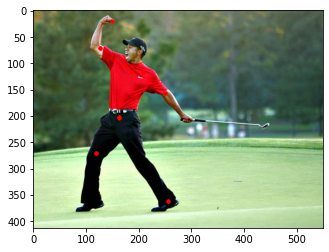

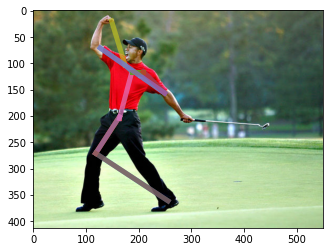

In [38]:
image_SHN, keypoints_SHN = predict(model_SHN, test_image)
draw_keypoints_on_image(image_SHN, keypoints_SHN)
draw_skeleton_on_image(image_SHN, keypoints_SHN)

## Simplebaseline 학습(실패)

In [ ]:
best_model_SBL_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, 'model_SBL', is_stackedhourglassnetwork=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 마무리

## 어려웠던 점

- simplebaseline이 무엇인지 아직도 모르겠다(학습이 안됨)

- 병렬 프로그래밍은 로컬 환경의 주피터 노트북으로 실행이 제대로 안됨

- 시간이 너무 많이 걸렸음

## 결론

마지막 프로젝트인 만큼 잘해보자라는 생각을 가지고 있었지만,

역시 마지막이라서 그런지 난이도가 매우 높았다.

simplebaseline을 구현은 성공했는데 학습을 돌릴때 저 상태에서 진행이 안되었다.

참고할 깃허브가 아예 없어 구현을 성공하더라고 맞게 성공한것인지 확인도 못할것이다.

StackedHourglass 모델은 5에포크 인데도 불구하고 많은 시간을 잡아먹었다.

학습결과도 그다지 좋지 않은것으로 보인다.

여러모로 기쁘지 않은 프로젝트였다.